## Portuguese
### sklearn active learning loop

- figure out where to incorporate dev set: if not needed use it to enlarge train set
- try out query by commitee - can try out in portuguese learning loop and compare to the loop in spanish notebook
- try out different query strategy

sources:

https://colab.research.google.com/drive/1G_4o-1_CkR4eNgzGVcx89IJ_lKLBQQv-?usp=sharing#scrollTo=zzfQjODjFwDs

sklearn: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

fasttext & sklearn: https://ai.intelligentonlinetools.com/ml/fasttext-word-embeddings-text-classification-python-mlp/

Keras AL tutorial: https://keras.io/examples/nlp/active_learning_review_classification/?utm_source=pocket_mylist
for torch nn.model : https://towardsdatascience.com/deep-learning-for-nlp-with-pytorch-and-torchtext-4f92d69052f

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import  preprocessing
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
import rubrix as rb
import webbrowser

/Users/maxine/Library/Python/3.9/lib/python/site-packages/jose/backends/cryptography_backend.py:18: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes, int_to_bytes


## 1) Data
- initial_train: labeled test set ('seed')
- pool: pool of unlabeled data
- test: small labeled test set


In [2]:
# 1) (index), text, label
# initial_train = pd.read_csv('Users/Maxine/Desktop/se_corpus/ud/pt_data/pt_bosque-ud-train.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) # macbook
initial_train = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/pt_data/pt_bosque-ud-train.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) #imac
initial_train.drop(columns=['text'], inplace = True)

# test = pd.read_csv('/Users/Maxine/Desktop/se_corpus/ud/pt_data/pt_bosque-ud-test.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # macbook
test = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/pt_data/pt_bosque-ud-test.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # imac
test.drop(columns=['text'], inplace = True)

# pool = pd.read_csv('/Users/Maxine/Desktop/se_corpus/corpusdata_org/pt_text_se_corpus.txt', names=['text'], sep='\t') # 1 col data containing comma values # macbook
pool = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/corpusdata_org/pt_text_se_corpus.txt', names=['text'], sep='\t') # 1 col data containing comma values # imac

# Note: for some reason jupyter cannot find the relative path

In [3]:
initial_train.shape, test.shape, pool.shape

((948, 2), (155, 2), (49867, 1))

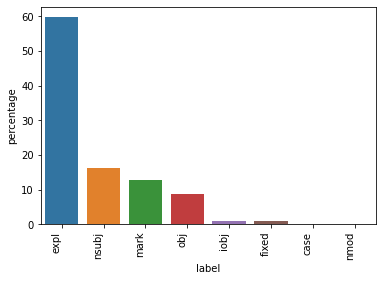

In [4]:
"""
check label distribution in splits
"""
def get_class_dist(df_col):
    data = df_col.value_counts(normalize=True).rename('percentage').mul(100).reset_index().rename(columns = {"index":"label"})
    plot = sns.barplot(x="label", y="percentage", data=data)
    plot.set_xticklabels(plot.get_xticklabels(),
                          rotation=90,
                          horizontalalignment='right')

get_class_dist(initial_train.se_label)

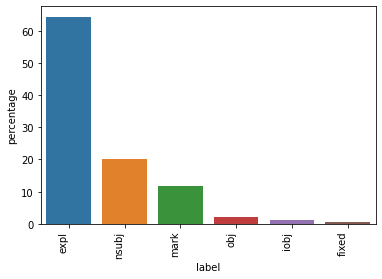

In [5]:
get_class_dist(test.se_label)

In [ ]:
# eventually save the plots
# plt.savefig('filename.png')
# plt.show()

In [9]:
"""
drop labels case (2) and nmod (1)
other than in spanish, 'fixed' is a valid Ud label in portuguese (E como se estivesse lá (eng. It is as if 3pSg were here))
"""
initial_train = initial_train.drop(initial_train[(initial_train['se_label'] == 'case')].index)
initial_train = initial_train.drop(initial_train[(initial_train['se_label'] == 'nmod')].index)

In [11]:
def get_balanced_set(df):
    max_size = df['se_label'].value_counts().max()
    balanced_list = [df]
    for class_index, group in df.groupby('se_label'):
        balanced_list.append(group.sample(max_size-len(group), replace=True))
    return pd.concat(balanced_list)

In [16]:
balanced_train = get_balanced_set(initial_train)
print('size train set: ', initial_train.shape, '\nsize oversampled test set: ', balanced_train.shape)

size train set:  (945, 2) 
size oversampled test set:  (3396, 2)


In [ ]:
"""
eventually implement fasttext word embeddings instead of CountVectorizer()
"""
# import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # todo change to es
# ft = fasttext.load_model('cc.en.300.bin') # rename model

In [17]:
label_encoder = preprocessing.LabelEncoder()
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(initial_train.tokenized_text)
X_balanced_train = vectorizer.transform(balanced_train.tokenized_text)
X_test = vectorizer.transform(test.tokenized_text)
X_pool = vectorizer.transform(pool.text)

y_train = label_encoder.fit_transform(initial_train.se_label)
y_balanced_train = label_encoder.transform(balanced_train.se_label)
y_test = label_encoder.transform(test.se_label)

In [21]:
# check assigned values
print(list(label_encoder.classes_), label_encoder.transform(['expl', 'fixed', 'iobj', 'mark', 'nsubj', 'obj']))

['expl', 'fixed', 'iobj', 'mark', 'nsubj', 'obj'] [0 1 2 3 4 5]


## 2) Model
- check accuracy values of different classifiers
- check performance of class_weight= ‘balanced’
- compare performance on train and balanced train


In [27]:
"""
the leat populated class only has 9 memebers, so 10-fold cross validation isn't accurate. Use oversampled set from the start (justification: proved to allow for more accurate training in the spanish notebook)
"""

models = [
    LinearSVC(multi_class='ovr', max_iter=3000),
    LogisticRegression(max_iter=1000),
    MultinomialNB(fit_prior=True),
]

cross_val = 10

df_cross_val = pd.DataFrame(index=range(cross_val * len(models)))
performances = []

for model in models:
    parameters = model.get_params()
    if 'class_weight' in parameters.keys():
        if parameters['class_weight'] == 'balanced':
            model_name = model.__class__.__name__ + '_balanced'
        else:
            model_name = model.__class__.__name__
    else:
        model_name = model.__class__.__name__
    f1_scores = cross_val_score(model,X_balanced_train, y_balanced_train, scoring='f1_weighted',cv=cross_val)
    for fold_index, f1_score in enumerate(f1_scores):
        performances.append((model_name, fold_index, f1_score))

df_cross_val = pd.DataFrame(performances, columns=['model', 'fold_index', 'f1_score_weighted'])
print(df_cross_val.groupby('model').f1_score_weighted.mean())

model
LinearSVC             0.969327
LogisticRegression    0.969312
MultinomialNB         0.910182
Name: f1_score_weighted, dtype: float64


Output:
X_Train
LinearSVC                      0.555151
LinearSVC_balanced             0.554284
LogisticRegression             0.523730
LogisticRegression_balanced    0.555238
MultinomialNB                  0.498976
Name: f1_score_weighted, dtype: float64

LogisticRegression_balanced gets highest f1-score.

Spanish:
model
LinearSVC                      0.488250
LinearSVC_balanced             0.487004
LogisticRegression             0.482708
LogisticRegression_balanced    0.490563
MultinomialNB                  0.469553
Name: f1_score_weighted, dtype: float64

check whether accuracy improves when we use over-sampled data

In [28]:
targets = label_encoder.classes_

clf = LogisticRegression(max_iter=1000)

# 1) oversampled training data
clf.fit(X_balanced_train, y_balanced_train)

y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=targets, zero_division=0))

              precision    recall  f1-score   support

        expl       0.70      0.86      0.77       100
       fixed       0.00      0.00      0.00         1
        iobj       0.00      0.00      0.00         2
        mark       0.46      0.33      0.39        18
       nsubj       0.22      0.13      0.16        31
         obj       0.00      0.00      0.00         3

    accuracy                           0.62       155
   macro avg       0.23      0.22      0.22       155
weighted avg       0.55      0.62      0.58       155



best model setting:
LogisticRegression(class_weight='balanced')
with balanced/oversampled training set
and inital test set

## 3) Active Learner

In [36]:
"""
Initialize the ActiveLearner with the fitted classifier
"""
learner = ActiveLearner(estimator=LogisticRegression(max_iter=10000),
                        query_strategy=uncertainty_sampling,
                        X_training=X_balanced_train, y_training=y_balanced_train
                        )

In [37]:
n_instances = 10
# accuracies = []
accuracies = [learner.score(X_test, y_test)]

### Loop
- stops after 20 iterations
- opens the rubrix web interface
- waits for user response

Problem: if annotation is None (e.g in the case a sentence is discarded) the loop breaks. We have to discard certain sentences because when creating the underlying corpus
phrases that do not contain 'se' like 'aunque a tu mac no le pase nada' were not discarded because there is no suited programmatical way to differentiate btw. 'pase' and 'siéntese'.

In [38]:
"""
convert X_pool (scipy matrix) to numpy array
"""
X_pool = X_pool.toarray()

In [39]:
while len(accuracies) < 20:
    query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)
    probabilities = learner.predict_proba(X_pool[query_idx])
    records = [
        rb.TextClassificationRecord(
            id=idx,
            inputs=pool.text.iloc[idx],
            prediction=list(zip(['expl', 'fixed', 'iobj', 'mark', 'nsubj', 'obj'], probs)),
            # check assigned values
            prediction_agent="LogisticRegression",
        )
        for idx, probs in zip(query_idx, probabilities)
    ]

    # log the records
    rb.log(records, name="pt_sklearn_active_learning_se_corpus")
    webbrowser.get('firefox').open_new_tab('http://0.0.0.0:6900')

    input('confirm that annotations on rubrix are done')
    records_df = rb.load("pt_sklearn_active_learning_se_corpus", ids=query_idx.tolist(), as_pandas=False)
    annotation = [record.annotation for record in records_df]
    if None in annotation:
        print('Note: you either discarded samples or did not annotate all samples')
        discarded_idxs=[idx for idx, sample in enumerate(annotation) if sample is None]
        discarded_idxs = sorted(discarded_idxs, reverse=True)
        for index in discarded_idxs:
            query_inst = np.delete(query_inst, index, axis=0)
        annotation = list(filter(None.__ne__, annotation))

    # train the classifier with the newly annotated examples
    y_pool = label_encoder.transform(annotation)
    learner.teach(query_inst, y_pool)
    accuracies.append(learner.score(X=X_test, y=y_test))

    X_pool = np.delete(X_pool, query_idx, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus
Note: you either discarded samples or did not annotate all samples


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus
Note: you either discarded samples or did not annotate all samples


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus
Note: you either discarded samples or did not annotate all samples


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus
Note: you either discarded samples or did not annotate all samples


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus
Note: you either discarded samples or did not annotate all samples


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus
Note: you either discarded samples or did not annotate all samples


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus
Note: you either discarded samples or did not annotate all samples


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus
Note: you either discarded samples or did not annotate all samples


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus
Note: you either discarded samples or did not annotate all samples


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/sklearn_active_learning_se_corpus


ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

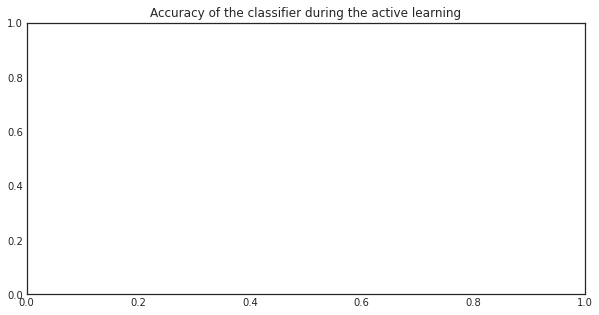

In [3]:

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(n_instances+1), accuracies)
    plt.scatter(range(n_instances+1), accuracies)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()

In [2]:
print(max(accuracies))

NameError: name 'accuracies' is not defined

In [ ]:
"""
save the samples and the annotations
"""
dataset_rb = rb.load("pt_sklearn_active_learning_se_corpus", as_pandas=True)
dataset_rb.to_csv('pt_sklearn_annotations.txt')